## Logistic Regression:

#### Objective
================
1. Apply Logistic regression on all the four vectorizers.
2. Before applying the model, please read the sklearn documentation and go through all
the parameters that it can accept and try to use some in your assignment if you think that
can help somehow
3. Performing perturbation test:
a. Get the weights W after fit your model with the data X.
b. Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)
c. we fit the model again on data X' and get the weights W'
d. Add the small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6
find the % change between W and W' (| (W-W') / (W) |)*100)
e. print the features whose % change is more than a threshold x, (you need to
choose this threshold using elbow method)

4. Choose different metric other than accuracy for choosing the best hyperparameter,
which is apt for imbalanced datasets and accuracy sometimes gives us false conclusions
about the model performance sometimes.
5. Do hyperparameter tuning or some feature engineering and make your model better by
reducing the false positives. (Ex: adding the length of the reviews, getting some features
from the summary column)
6. Get important features for both positive and negative classes separately.
7. Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is
recommended.
8. Avoid submitting the models which are more biased towards positive points. Try to
improve if everything or most of the points are predicting as positive.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
#taking cleaned data i.e in Reviews table  from final sql database
#making connection with database 
conn = sqlite3.connect('final.sqlite') 
final = pd.read_sql_query(""" SELECT * FROM Reviews ORDER BY Time""", conn) 


C:\Users\nisha\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
final = final[:100000]
print(len(final))

100000


In [3]:
CleanedText = final['CleanedText'];
text=final.CleanedText.values
#print(CleanedText)
CleanedText_Class = [];
for i in final['Score']:
    if (i == 'positive'):
        CleanedText_Class.append(1)
    else:
        CleanedText_Class.append(0)
    

### Spliting the original data into Train,CV and Test

In [4]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
# ====================================
# split the data set into train and test for BoW
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
X_1, X_test, y_1, y_test = cross_validation.train_test_split(text, CleanedText_Class, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import os

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from wordcloud import WordCloud
import seaborn as sns; 
def most_informative_feature_for_binary_classification(vectorizer, w,n_features,is_print = True):
#     class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(w, feature_names), reverse=False)[:n_features]
    topn_class2 = sorted(zip(w, feature_names), reverse=True)[:n_features]
#     print(feature_names)
    if is_print == True:
        print("\nTop %s negative features"% (n_features))
        for w, feat in topn_class1:
            print( w, feat)
        
        print("\nTop %s positive features" %(n_features))
#         for w, feat in reversed(topn_class2):
        for w, feat in topn_class2:
            print(w, feat)
        
    else:
        top_features_dict ={};
        top_negative_features_name_list =[]
        top_positive_features_name_list =[]
        for coef, feat in topn_class1:
            top_negative_features_name_list.append(feat)
            
#         for coef, feat in reversed(topn_class2):
        for coef, feat in topn_class2:
            top_positive_features_name_list.append(feat)
            
        top_features_dict ={"top_negative_features_name_list":top_negative_features_name_list,"top_positive_features_name_list":top_positive_features_name_list}
        return top_features_dict;


def top_features_wordcloud_generated_image_fun(features_list):
    wordcloud = WordCloud(width=600, height=600, margin=0,background_color="white").generate(" ".join(features_list))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    
def collinear_features_fun(vectorizer, w):
    feature_names = vectorizer.get_feature_names()
    topn_class2 = sorted(zip(w, feature_names), reverse=True)[:] 
    features_list = []
    for coef, feat in topn_class2:
        if coef != 0.0 :
            features_list.append(feat)
                
    collinear_features = features_list;
    return collinear_features;
    

## Bow
#### Applying Bow vectorizer on data

In [6]:
#BOW 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vocabulary= vectorizer.fit(X_tr)
#print("the shape of out text BOW vectorizer ",vocabulary.get_shape())
#bow_x_tr.shape
# bow_tr_array

In [7]:
bow_x_tr= vectorizer.transform(X_tr)
print("the shape of out text BOW vectorizer ",bow_x_tr.get_shape())

the shape of out text BOW vectorizer  (49000, 26676)


In [8]:
bow_x_cv= vectorizer.transform(X_cv)
print("the shape of out text BOW vectorizer ",bow_x_cv.get_shape())

the shape of out text BOW vectorizer  (21000, 26676)


### Doing col-std on Bow train and CV

In [9]:
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
# print(scaler.fit(bow_x_tr))
# print(scaler.mean_)
Standardize_bow_x_tr= scaler.fit_transform(bow_x_tr)
# print(Standardize_bow_x_tr)
# print(scaler.mean_)
Standardize_bow_x_cv= scaler.fit_transform(bow_x_cv)
# print(Standardize_bow_x_cv)
# print(scaler.mean_)

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Apply GridSearch on Bow

In [10]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(Standardize_bow_x_tr, y_tr)

print(model.best_estimator_)
print(model.score(Standardize_bow_x_cv, y_cv))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9520186460203071


### with optimal value of lambda using l1 reg on train data

In [10]:
## after getting optimal lambda with optimal value of lambda, performance of train with other matrix i.e weighted f1
optimal_lambda = 0.01
clf = LogisticRegression(C=optimal_lambda, penalty='l1');
clf.fit(Standardize_bow_x_tr, y_tr);
w = clf.coef_
# print(np.count_nonzero(w))
# predict the response
pred = clf.predict(Standardize_bow_x_cv)

# evaluate accuracy
sc = f1_score(y_cv, pred,average="weighted") * 100
print('\nThe weighted f1_score of the LogisticRegression with l1 for C = 0.01  is %f%%' % ( sc))
print('\nfitting the model with l1 the Sparsity W  is %d' % (np.count_nonzero(w)))


The weighted f1_score of the LogisticRegression with l1 for C = 0.01  is 90.900182%

fitting the model with l1 the Sparsity W  is 2279


## Performing perturbation test:

*********************************** pertubation test Start *****************************************************

#### After getting the weights W after fit your model with the train data X i.e Standardize_bow_x_tr.
###### Adding noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e) that is e = 0.01
###### we have sparse matrix so we will use X.data+=e

In [66]:
print(Standardize_bow_x_tr.shape);
Standardize_bow_x_tr_dash = Standardize_bow_x_tr
Standardize_bow_x_tr_dash.data = Standardize_bow_x_tr_dash.data + 0.01;
print(Standardize_bow_x_tr_dash.shape)

(49000, 26688)
(49000, 26688)


#### we fit the model again on train data X' i.e Standardize_bow_x_tr_dash  and get the weights w_dash

In [67]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 
#afer adding some noise to the data 
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(Standardize_bow_x_tr_dash, y_tr);
w_dash = clf.coef_
# print(np.count_nonzero(w))
# predict the response
pred = clf.predict(Standardize_bow_x_cv)

# evaluate accuracy
sc = f1_score(y_cv, pred) * 100
print('\nThe f1_score of the LogisticRegression with l1 for C = 0.01  is %f%%' % ( sc))

print('\n after pertubation fitting the model X'' with l1 the Sparsity W''  is %d' % (np.count_nonzero(w_dash)))


The f1_score of the LogisticRegression with l1 for C = 0.01  is 95.496915%

 after pertubation fitting the model X with l1 the Sparsity W  is 2280


#### Add the small eps value(to eliminate the divisible by zero error) to W and W_dash i.e W=W+10^-6 and W_dash = W_dash+10^-6


In [68]:
w = w[0] + 0.000001;
w_dash = w_dash[0] +0.000001;
W = list(w)
W_Dash = list(w_dash)

#### find the % change between W and W' (| (W-W') / (W) |)*100)

In [69]:
change_vector_percentage = []
# count = 0;
for i in tqdm(range(0,len(W))):
    change_vector = 0
    change_vector=(abs((W[i]-(W_Dash[i]))/(W[i])))*100
    change_vector_percentage.append(change_vector)
#     count = count+1;
#     print("w = %f and w_dash = %f and chnage %f"%(W[i] ,W_Dash[i],change_vector))



100%|████████████████████████████████████████████████████████████████████████| 26688/26688 [00:00<00:00, 445074.55it/s]


#### calculating the 0th, 10th, 20th, 30th, ...100th percentiles, and observing any sudden rise in the values of percentage_change_vector



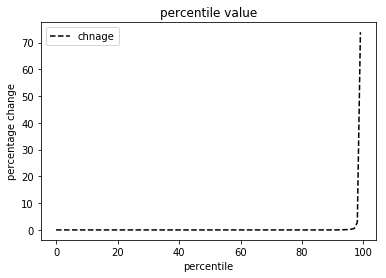

In [16]:
percentile_value = []
percentile = []
i= 0
while i <100:
    percentile.append(i)
    percentile_value.append(np.percentile(change_vector_percentage,i))
    i = i+1;
    
# percentile_value
plt.plot(percentile, percentile_value, 'k--',label='chnage')
plt.xlabel('percentile')
plt.ylabel('percentage change')
plt.title("percentile value")
plt.legend()
plt.show()

#### As we can see in our graph at approx between 90 and 100 we have sudden rise let's look it by printing percentile between 90 and 100

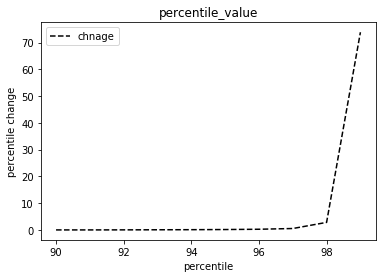

Percentile value from 90 to 99

[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0.0, 0.0, 0.020159442543854773, 0.052269603834834574, 0.08781353724260281, 0.14239281909487844, 0.25013147759295945, 0.523601557151551, 2.8118883126785033, 73.88894828928194]


In [17]:
ninty_percentile_val = []
ninty_percentile = []
j= 90
while j <100:
    ninty_percentile.append(j)
    ninty_percentile_val.append(np.percentile(change_vector_percentage,j))
    j = j+1;
    
plt.plot(ninty_percentile, ninty_percentile_val, 'k--',label='chnage')
plt.xlabel('percentile')
plt.ylabel('percentile change')
plt.title("percentile_value")
plt.legend()
plt.show()

print("Percentile value from 90 to 99\n")
print(ninty_percentile)
print(ninty_percentile_val)


#### As we can see its at 98 we are getting the elbow lets print the percentile between 98.0 and 99.0

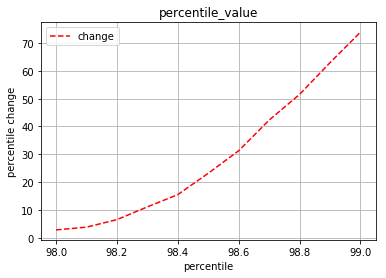

Percentile value from 98.0 to 99.0

[98, 98.1, 98.19999999999999, 98.29999999999998, 98.39999999999998, 98.49999999999997, 98.59999999999997, 98.69999999999996, 98.79999999999995, 98.89999999999995, 98.99999999999994]
[2.8118883126785033, 3.8049729222408746, 6.513651530835544, 11.092098080301525, 15.50777873546066, 23.170988960363005, 31.273028306804147, 42.27482308671724, 51.529703857949826, 62.93721548916252, 73.88894828927036]


In [50]:
ninty_percentile_val = []
ninty_percentile = []
j= 98
while j <=99:
    ninty_percentile.append(j)
    ninty_percentile_val.append(np.percentile(change_vector_percentage,j))
    j = j+0.1;
    
plt.plot(ninty_percentile, ninty_percentile_val, 'r--',label='change')
plt.xlabel('percentile')
plt.ylabel('percentile change')
plt.title("percentile_value")
plt.legend()
plt.grid()
plt.show()

print("Percentile value from 98.0 to 99.0\n")
print(ninty_percentile)
print(ninty_percentile_val)


##### As we can see above at 98.4 percentile we got our elbow and the value at that is 15.50 and that is our thresold 
#####  and after getting threshold the features I will print which has more than threshold why? -- they are the features which are affected by simple noise, so they are multicollinear with some other features if any of these features are in important features then we can't trust the top features.


In [70]:
w_with_greater_than_thresold = []
# temp_weight = list(w[0])
count = 0;
for i in range(0,len(change_vector_percentage)):
    if change_vector_percentage[i] > 15.50:
        count = count +1;
        w_with_greater_than_thresold.append(w[i])
#         print("index i = %d weight = %f of and percentage change is %f" %(i, (w[i]),change_vector_percentage[i]));
    else:
        w_with_greater_than_thresold.append(0.0)
        
print(count)
# print(len(change_vector_percentage))
# print(len(w[0]))

408


###  Feature names whose % change is more than a threshold x (collinear_features)

In [81]:
features_with_greater_than_thresold = collinear_features_fun(vectorizer,w_with_greater_than_thresold)
print(features_with_greater_than_thresold)

['venison', 'grimyest', 'brunt', 'heksher', 'esselstyn', 'rooki', 'mink', 'thensuggest', 'botox', 'aagh', 'underworld', 'sissorhand', 'sweetgum', 'bambi', 'deic', 'loxi', 'fuctos', 'pokish', 'macduffi', 'hugrygirl', 'adrift', 'thwack', 'aardvark', 'stewrt', 'flamin', 'tommorow', 'ronni', 'gfi', 'ah', 'hooki', 'puka', 'corser', 'reincarn', 'picata', 'gookum', 'dya', 'surimi', 'comar', 'whippl', 'samui', 'napili', 'caldwel', 'gunni', 'mauro', 'metrx', 'enrichen', 'to', 'tentacl', 'addam', 'internatur', 'stich', 'underhand', 'iattc', 'fsm', 'sandworm', 'minion', 'kamehameha', 'costliest', 'giberish', 'healthi', 'peligrino', 'hhhhhhhotttttttt', 'po', 'garrison', 'considerationt', 'superpow', 'methanol', 'poptop', 'hodgepodg', 'cuss', 'soli', 'conventi', 'dabomb', 'bluebird', 'typhoon', 'lullabi', 'tromp', 'bagsonboard', 'hick', 'psychosomat', 'fuego', 'waimea', 'bevmo', 'oddest', 'espi', 'hottier', 'skillz', 'hydrant', 'vigil', 'interestng', 'gfer', 'monsieur', 'quoto', 'turner', 'whad', '

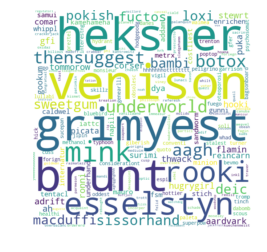

In [79]:
top_features_wordcloud_generated_image_fun(features_with_greater_than_thresold)

*********************************** pertubation test Ends *****************************************************

## Getting Top important Features for Both the Class

In [31]:
most_informative_feature_for_binary_classification(vectorizer,w[0],10)


Top 10 negative features
-0.28890341715424744 disappoint
-0.21334441063112916 worst
-0.1700453232113178 terribl
-0.16148273767396576 aw
-0.14090148938905467 bad
-0.13446195847666262 unfortun
-0.13323899974025405 money
-0.13309229083108887 would
-0.1300940760309349 horribl
-0.1270421540332491 return

Top 10 positive features
0.6095259218706532 great
0.45837238593224516 love
0.43745995683343253 best
0.3760858808759966 delici
0.3036665132602096 perfect
0.2827081793163093 excel
0.2774050602651199 good
0.23540424953637562 favorit
0.20330285013595453 wonder
0.20106032252511727 nice


In [32]:
top_features = most_informative_feature_for_binary_classification(vectorizer,w[0],20,False)

### Top Negative Feaures 

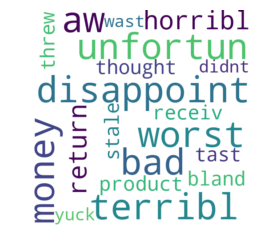

In [33]:
top_features_wordcloud_generated_image_fun(top_features["top_negative_features_name_list"])

### Top Positive Features

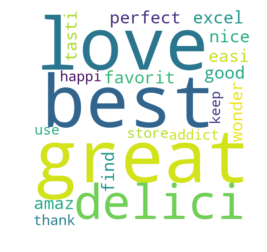

In [34]:
top_features_wordcloud_generated_image_fun(top_features["top_positive_features_name_list"])

## LogisticRegression implementation with l1 and l2 reg After getting optimal lambda

### with optimal value of lambda using l2 reg on train data 

In [36]:
## after getting optimal lambda with optimal value of lambda, performance of train with other matrix i.e weighted f1
optimal_lambda = 0.01
clf = LogisticRegression(C=optimal_lambda, penalty='l2');
clf.fit(Standardize_bow_x_tr, y_tr);
w = clf.coef_
# print(np.count_nonzero(w))
# predict the response
pred = clf.predict(Standardize_bow_x_cv)

# evaluate accuracy
sc = f1_score(y_cv, pred,average="weighted") * 100
print('\nThe weighted f1_score of the LogisticRegression with l2 for C = 0.01  is %f%%' % ( sc))
# print('\nfitting the model with l1 the Sparsity W  is %d' % (np.count_nonzero(w)))


The weighted f1_score of the LogisticRegression with l2 for C = 0.01  is 91.255422%


### With change in Hyperparameter 

In [94]:
i= 0.0001;
Sparsity_list = []
lambda_list = []
performance_list = []
while i< 100:
    clf = LogisticRegression(C=i, penalty='l1');
    clf.fit(Standardize_bow_x_tr, y_tr);
    w = clf.coef_
    pred = clf.predict(Standardize_bow_x_cv)
    # evaluate f1_score
    sc = f1_score(y_cv, pred) * 100
#     print("-------------------------------------------------------")
#     print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (i, sc))
#     print('\nfitting the model with l1 the Sparsity W  is %d' % (np.count_nonzero(w)))
    Sparsity_list.append(np.count_nonzero(w))
    lambda_list.append(i)
    performance_list.append(sc)
    i=i*10;
    
 

### Ploting the Graph for lambda and Sparsity 

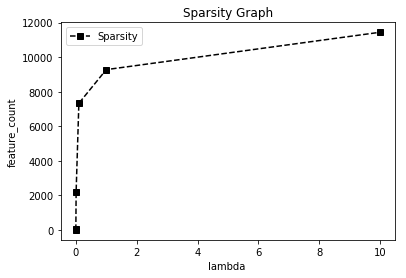

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
[0, 29, 2207, 7330, 9278, 11442]


In [96]:
plt.plot(lambda_list, Sparsity_list, 'ks--',label='Sparsity')
plt.xlabel('lambda ')
plt.ylabel('feature_count')
plt.title("Sparsity Graph")
plt.legend()
plt.show()
print(lambda_list)
print(Sparsity_list)

### Ploting the Graph for lambda and Performance

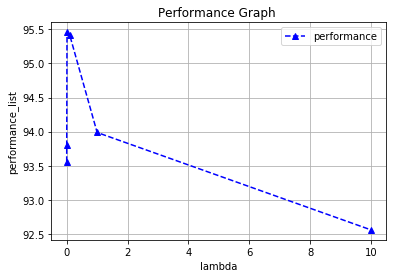

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
[93.5577069288864, 93.80913622952487, 95.45764847975634, 95.41491159820782, 93.98797049778189, 92.55921305709732]


In [98]:
plt.plot(lambda_list, performance_list, 'b^--' ,label='performance')
plt.xlabel('lambda')
plt.ylabel('performance_list')
plt.title("Performance Graph ")
plt.legend()
plt.grid()
plt.show()
print(lambda_list)
print(performance_list)

### Apply RandomizedSearchCV on Bow

In [63]:
from sklearn.model_selection import RandomizedSearchCV
Randomized_parameters = {'C': np.random.uniform(0.0001,10,10000)}

#Using GridSearchCV
model = RandomizedSearchCV(LogisticRegression(), Randomized_parameters, scoring = 'f1', cv=5)
model.fit(Standardize_bow_x_tr, y_tr)

print(model.best_estimator_)
print(model.score(Standardize_bow_x_cv, y_cv))

LogisticRegression(C=0.9931798006924732, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9272045336326553


### Performance measure of Test Data on Trained Model with optimal value of lambda with different performance metrix

In [11]:
# vectorizing the test data into Bow for model implimentation 
bow_x_test= vectorizer.transform(X_test)
print("the shape of out text BOW vectorizer ",bow_x_test.get_shape())

Standardize_bow_x_test= scaler.fit_transform(bow_x_test)
# print(Standardize_bow_x_test)
# print(scaler.mean_)

the shape of out text BOW vectorizer  (30000, 26676)


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
#apply LogisticRegression,l1 reg ,with performace weighted matrix f1_score on bow with optimal value of lambda 
clf = LogisticRegression(C=optimal_lambda, penalty='l1');
clf.fit(Standardize_bow_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_bow_x_test)

# evaluate weighted f1_score
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (optimal_lambda, sc))


The weighted f1_score of the LogisticRegression with l1 for C = 0.010000  is 90.456263%


In [44]:
#apply LogisticRegression,l1 reg ,with performace matrix f1_score on bow with optimal value of lambda 
clf = LogisticRegression(C=optimal_lambda, penalty='l1');
clf.fit(Standardize_bow_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_bow_x_test)

# evaluate f1_score
sc = f1_score(y_test, pred) * 100
print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (optimal_lambda, sc))


The f1_score of the LogisticRegression with l1 for C = 0.010000  is 95.354325%


In [45]:
#apply LogisticRegression,l1 reg ,with performace recall_score on bow with optimal value of lambda 
clf = LogisticRegression(C=optimal_lambda, penalty='l1');
clf.fit(Standardize_bow_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_bow_x_test)
# evaluate recall_score
sc = recall_score(y_test, pred) * 100
print('\nThe recall_score of the LogisticRegression with l1 for C = %f  is %f%%' % (optimal_lambda, sc))


The recall_score of the LogisticRegression with l1 for C = 0.010000  is 98.551995%


In [46]:
#apply LogisticRegression,l1 reg ,with performace precision_score on bow with optimal value of lambda 
clf = LogisticRegression(C=optimal_lambda, penalty='l1');
clf.fit(Standardize_bow_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_bow_x_test)
# evaluate precision_score
sc = precision_score(y_test, pred) * 100
print('\nThe precision_score of the LogisticRegression with l1 for C = %f  is %f%%' % (optimal_lambda, sc))


The precision_score of the LogisticRegression with l1 for C = 0.010000  is 92.358507%



The confusion_matrix of the LogisticRegression with l1 for C = 0.010000 
[[ 1618  2139]
 [  380 25863]]


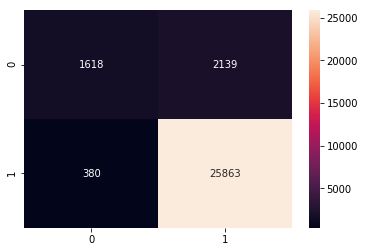

In [47]:
#apply LogisticRegression,l1 reg ,with performace confusion_matrix on bow with optimal value of lambda 
clf = LogisticRegression(C=optimal_lambda, penalty='l1');
clf.fit(Standardize_bow_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_bow_x_test)
# evaluate confusion_matrix
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix of the LogisticRegression with l1 for C = %f ' % (optimal_lambda))
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [48]:
#apply LogisticRegression,l1 reg ,with performace confusion_matrix on bow with optimal value of lambda 
clf = LogisticRegression(C=optimal_lambda, penalty='l1');
clf.fit(Standardize_bow_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_bow_x_test)
# evaluate confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix for alpha = %f " %(optimal_lambda))

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for BOW *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix for alpha = 0.010000 

******* for BOW *********

****TPR is 98%

****FPR is 56%

****FNR is 1%

****TNR is 43%


*********Bow Ends***

## TF-IDF

In [12]:
#tfidf 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocabulary = tf_idf_vect.fit(X_tr)
#print("the shape of out text TF-IDF vectorizer ",tf_idf_x_tr.get_shape())

In [13]:
tf_idf_x_tr = tf_idf_vect.transform(X_tr)
print("the shape of out text TF-IDF vectorizer ",tf_idf_x_tr.get_shape())

the shape of out text TF-IDF vectorizer  (49000, 727227)


In [14]:
tf_idf_x_cv = tf_idf_vect.transform(X_cv)
print("the shape of out text TF-IDF vectorizer ",tf_idf_x_cv.get_shape())

the shape of out text TF-IDF vectorizer  (21000, 727227)


###  col-std on TF-IDF train and CV

In [15]:
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
# print(scaler.fit(bow_x_tr))
# print(scaler.mean_)
Standardize_tf_idf_x_tr= scaler.fit_transform(tf_idf_x_tr)
# print(Standardize_bow_x_tr)
# print(scaler.mean_)
Standardize_tf_idf_x_cv= scaler.fit_transform(tf_idf_x_cv)
# print(Standardize_bow_x_cv)
# print(scaler.mean_)

### Apply GridSearch on TF-IDF

In [53]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(Standardize_tf_idf_x_tr, y_tr)

print(model.best_estimator_)
print(model.score(Standardize_tf_idf_x_cv, y_cv))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9448686192895994


#### with optimal value of lambda using l1 reg on train data

In [16]:
tfidf_optimal_lambda = 100
clf = LogisticRegression(C=tfidf_optimal_lambda, penalty='l1');
clf.fit(Standardize_tf_idf_x_tr, y_tr);
w = clf.coef_
# print(np.count_nonzero(w))
# predict the response
pred = clf.predict(Standardize_tf_idf_x_cv)

# evaluate accuracy
sc = f1_score(y_cv, pred) * 100
print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_optimal_lambda, sc))
print('\nfitting the model with l1 the Sparsity W  is %d' % (np.count_nonzero(w)))


The f1_score of the LogisticRegression with l1 for C = 100.000000  is 94.422372%

fitting the model with l1 the Sparsity W  is 141178


### Getting Top important Features for Both the Class

In [56]:
most_informative_feature_for_binary_classification(tf_idf_vect,w[0],10)


Top 10 negative features
-0.3573112053506788 aw
-0.14553847125238942 dont wast
-0.13460295406364797 disappoint
-0.1241063225116893 didnt tast
-0.11552011498851367 disappoint product
-0.11445652971756992 although dog
-0.11419099887816245 avoid product
-0.11098886289317822 bad batch
-0.1106123309234584 bland
-0.10829501815408205 condit good

Top 10 positive features
0.6965841480996122 delici
0.5069662991098497 add
0.4858527295364267 best
0.37601093253363843 cant
0.36485028046837986 better
0.33921929724272104 anoth
0.326640790555078 arriv
0.32180995396179346 buy
0.31955035838236867 altern
0.31598152406655045 bread


In [57]:
top_features = most_informative_feature_for_binary_classification(tf_idf_vect,w[0],20,False)

### Top Negative features

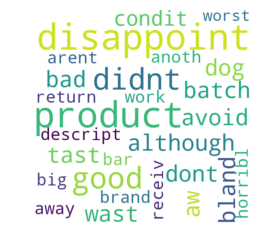

In [58]:
top_features_wordcloud_generated_image_fun(top_features["top_negative_features_name_list"])

### Top Positive features

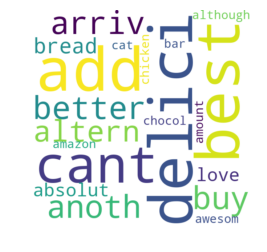

In [60]:
top_features_wordcloud_generated_image_fun(top_features["top_positive_features_name_list"])

### with optimal value of lambda using l2 reg on train data

In [17]:
# tfidf_optimal_lambda = 100
clf = LogisticRegression(C=tfidf_optimal_lambda, penalty='l2');
clf.fit(Standardize_tf_idf_x_tr, y_tr);
w = clf.coef_
# print(np.count_nonzero(w))
# predict the response
pred = clf.predict(Standardize_tf_idf_x_cv)

# evaluate accuracy
sc = f1_score(y_cv, pred) * 100
print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_optimal_lambda, sc))
print('\nfitting the model with l2 the Sparsity W  is %d' % (np.count_nonzero(w)))


The f1_score of the LogisticRegression with l1 for C = 100.000000  is 94.109515%

fitting the model with l2 the Sparsity W  is 728808


### With change in HyperParameter

In [104]:
i= 0.0001;
Sparsity_list = []
lambda_list = []
performance_list = []
while i< 100:
    clf = LogisticRegression(C=i, penalty='l1');
    clf.fit(Standardize_tf_idf_x_tr, y_tr);
    w = clf.coef_
    # predict the response
    pred = clf.predict(Standardize_tf_idf_x_cv)

    # evaluate f1_score
    sc = f1_score(y_cv, pred) * 100
#     print("-------------------------------------------------------")
#     print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (i, sc))
#     print('\nfitting the model with l1 the Sparsity W  is %d' % (np.count_nonzero(w)))
    Sparsity_list.append(np.count_nonzero(w))
    lambda_list.append(i)
    performance_list.append(sc)
    i=i*10; 

### Ploting the Graph for lambda and Sparsity

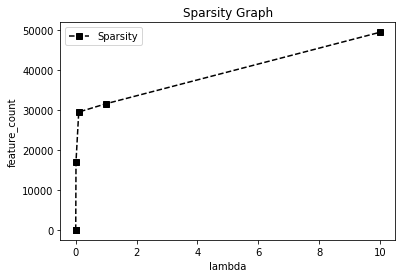

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
[0, 38, 17074, 29528, 31612, 49509]


In [105]:
plt.plot(lambda_list, Sparsity_list, 'ks--',label='Sparsity')
plt.xlabel('lambda')
plt.ylabel('feature_count')
plt.title("Sparsity Graph")
plt.legend()
plt.show()
print(lambda_list)
print(Sparsity_list)

### Ploting the Graph for lambda and Performance

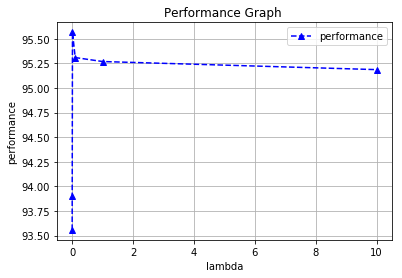

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
[93.5577069288864, 93.90622613653719, 95.56719937123394, 95.30992222484093, 95.26949241234955, 95.18722124260968]


In [107]:
plt.plot(lambda_list, performance_list, 'b^--' ,label='performance')
plt.xlabel('lambda')
plt.ylabel('performance')
plt.title("Performance Graph ")
plt.legend()
plt.grid()
plt.show()
print(lambda_list)
print(performance_list)

### Apply RandomizedSearchCV on TF-IDF

In [26]:
from sklearn.model_selection import RandomizedSearchCV
Randomized_parameters = {'C': np.random.uniform(0.0001,10,10000)}

#Using GridSearchCV
model = RandomizedSearchCV(LogisticRegression(), Randomized_parameters, scoring = 'f1', cv=5)
model.fit(Standardize_tf_idf_x_tr, y_tr)

print(model.best_estimator_)
print(model.score(Standardize_tf_idf_x_cv, y_cv))

LogisticRegression(C=7.843835189344414, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9457388105456774


### Performance measure of Test Data on Trained Model with optimal value of lambda with different performance metrix


In [17]:
tf_idf_x_test= tf_idf_vect.transform(X_test)
print("the shape of out text TF-IDF vectorizer ",tf_idf_x_test.get_shape())

the shape of out text TF-IDF vectorizer  (30000, 727227)


In [18]:
Standardize_tf_idf_x_test= scaler.fit_transform(tf_idf_x_test)
# print(Standardize_bow_x_test)
# print(scaler.mean_)

In [75]:
#apply LogisticRegression,l1 reg ,with performace weighted f1_score on TF-IDF with optimal value of lambda 
clf = LogisticRegression(C=tfidf_optimal_lambda, penalty='l1');
clf.fit(Standardize_tf_idf_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_tf_idf_x_test)

# evaluate weighted f1_score
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_optimal_lambda, sc))


The weighted f1_score of the LogisticRegression with l1 for C = 100.000000  is 86.725086%


In [76]:
#apply LogisticRegression,l1 reg ,with performace matrix f1_score on TF-IDF with optimal value of lambda 
clf = LogisticRegression(C=tfidf_optimal_lambda, penalty='l1');
clf.fit(Standardize_tf_idf_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_tf_idf_x_test)

# evaluate f1_score
sc = f1_score(y_test, pred) * 100
print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_optimal_lambda, sc))


The f1_score of the LogisticRegression with l1 for C = 100.000000  is 94.130261%


In [77]:
#apply LogisticRegression,l1 reg ,with performace recall_score on TF-IDF with optimal value of lambda 
clf = LogisticRegression(C=tfidf_optimal_lambda, penalty='l1');
clf.fit(Standardize_tf_idf_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_tf_idf_x_test)

# evaluate recall_score
sc = recall_score(y_test, pred) * 100
print('\nThe recall_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_optimal_lambda, sc))


The recall_score of the LogisticRegression with l1 for C = 100.000000  is 98.769196%


In [78]:
#apply LogisticRegression,l1 reg ,with performace precision_score on TF-IDF with optimal value of lambda 
clf = LogisticRegression(C=tfidf_optimal_lambda, penalty='l1');
clf.fit(Standardize_tf_idf_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_tf_idf_x_test)
# evaluate precision_score
sc = precision_score(y_test, pred) * 100
print('\nThe precision_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_optimal_lambda, sc))


The precision_score of the LogisticRegression with l1 for C = 100.000000  is 89.881324%



The confusion_matrix of the LogisticRegression with l1 for C = 100.000000 
[[  907  2850]
 [  343 25900]]


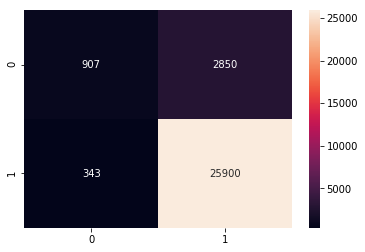

In [79]:
#apply LogisticRegression,l1 reg ,with performace confusion_matrix on TF-IDF with optimal value of alpha 
clf = LogisticRegression(C=tfidf_optimal_lambda, penalty='l1');
clf.fit(Standardize_tf_idf_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_tf_idf_x_test)
# evaluate confusion_matrix
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix of the LogisticRegression with l1 for C = %f ' % (tfidf_optimal_lambda))
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [80]:
#apply LogisticRegression,l1 reg ,with performace confusion_matrix on TF-IDF with optimal value of lambda 
clf = LogisticRegression(C=tfidf_optimal_lambda, penalty='l1');
clf.fit(Standardize_tf_idf_x_tr, y_tr);
# predict the response
pred = clf.predict(Standardize_tf_idf_x_test)
# evaluate confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix for alpha = %f " %(tfidf_optimal_lambda))

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for TF-IDF *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix for alpha = 100.000000 

******* for TF-IDF *********

****TPR is 98%

****FPR is 76%

****FNR is 1%

****TNR is 23%


*********TF-IDF Ends***

## Word2Vec

In [19]:
#Word2Vec mode 
#spliting train sentence in words 
# Train your own Word2Vec model using your own text corpus
i=0
X_tr_list_of_sent=[]
for sent in X_tr:
    X_tr_list_of_sent.append(sent.split())
    
print(len(X_tr))
# print("\n--------------Spliting each sentence into words--------word list of ie data corpus---------\n")
# print(X_tr_list_of_sent[:2])
#word list of ie data corpus

49000


In [20]:
#The Word to Vec model produces a vocabulary, with each word being represented by 
#an n-dimensional numpy array 
X_tr_w2v_model=Word2Vec(X_tr_list_of_sent,min_count=1,size=50, workers=4)
X_tr_w2v_model.wv['man']
wlist =list(X_tr_w2v_model.wv.vocab)
# wlist is a list of words 
len(wlist)

26676

#### Train for Avgword2vec

In [21]:
#CALCULATE AVG WORD2VEC FOR x_tr
w2v_words = list(X_tr_w2v_model.wv.vocab)
# compute average word2vec for each review.
X_tr_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_tr_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_tr_sent_vectors.append(sent_vec)
print(len(X_tr_sent_vectors))
print(len(X_tr_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [01:30<00:00, 539.83it/s]


49000
50


#### CV for Avgword2vec

In [22]:
#spliting cv sentence in words 
i=0
X_cv_list_of_sent=[]
for sent in X_cv:
    X_cv_list_of_sent.append(sent.split())
    
#word list of ie data corpus

In [23]:
#CALCULATE AVG WORD2VEC FOR x_cv 
# w2v_words = list(X_cv_w2v_model.wv.vocab)
w2v_words = list(X_tr_w2v_model.wv.vocab)

# compute average word2vec for each review in cv .
X_cv_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_cv_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
#             vec = X_cv_w2v_model.wv[word]
            vec = X_tr_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_sent_vectors.append(sent_vec)
print(len(X_cv_sent_vectors))
print(len(X_cv_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [00:47<00:00, 440.42it/s]


21000
50


### Avgword2vec on Test data 

In [24]:
#Train your own Word2Vec model using your own text corpus
#spliting test sentence in words 
i=0
X_test_list_of_sent=[]
for sent in X_test:
    X_test_list_of_sent.append(sent.split())
    
print(len(X_test_list_of_sent))

30000


In [25]:
#CALCULATE AVG WORD2VEC FOR x_test
# w2v_words = list(X_test_w2v_model.wv.vocab)

w2v_words = list(X_tr_w2v_model.wv.vocab)

# compute average word2vec for each review.
X_test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
#             vec = X_test_w2v_model.wv[word]
            vec = X_tr_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_sent_vectors.append(sent_vec)
print(len(X_test_sent_vectors))
print(len(X_test_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:05<00:00, 456.08it/s]


30000
50


### col-std on Avg word2vec train , CV and test

In [27]:
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
# print(scaler.fit(bow_x_tr))
# print(scaler.mean_)
Standardize_X_tr_sent_vectors= scaler.fit_transform(X_tr_sent_vectors)
# print(Standardize_bow_x_tr)
# print(scaler.mean_)
Standardize_X_cv_sent_vectors= scaler.fit_transform(X_cv_sent_vectors)
# print(Standardize_bow_x_cv)
# print(scaler.mean_)
Standardize_X_test_sent_vectors= scaler.fit_transform(X_test_sent_vectors)
# print(Standardize_bow_x_test)
# print(scaler.mean_)

### GridSearchCV on Avg word2vec

In [90]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=5)
model.fit(Standardize_X_tr_sent_vectors, y_tr)

print(model.best_estimator_)
print(model.score(Standardize_X_cv_sent_vectors, y_cv))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8932246320833327


#### with l1 reg on logistic regression apply f1_score as performance matrix on train with cv data with optimal lambda

In [28]:
#with l1 reg on logistic regression apply f1_score as performance matrix on train with cv data
Avg_word2vec_optimal_lambda = 100
clf = LogisticRegression(C=Avg_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_sent_vectors, y_tr);
w = clf.coef_
# print(np.count_nonzero(w))
# predict the response
pred = clf.predict(Standardize_X_cv_sent_vectors)

# evaluate f1_score
sc = f1_score(y_cv, pred) * 100
print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (Avg_word2vec_optimal_lambda, sc))
print('\nfitting the model with l1 the Sparsity W  is %d' % (np.count_nonzero(w)))


The f1_score of the LogisticRegression with l1 for C = 100.000000  is 94.806966%

fitting the model with l1 the Sparsity W  is 50


#### with l2 reg on logistic regression apply f1_score as performance matrix on train with cv data with optimal lambda

In [29]:
#with l2 reg on logistic regression apply f1_score as performance matrix on train with cv data
clf = LogisticRegression(C=Avg_word2vec_optimal_lambda, penalty='l2');
clf.fit(Standardize_X_tr_sent_vectors, y_tr);
w = clf.coef_
# print(np.count_nonzero(w))
# predict the response
pred = clf.predict(Standardize_X_cv_sent_vectors)

# evaluate f1_score
sc = f1_score(y_cv, pred) * 100
print('\nThe f1_score of the LogisticRegression with l2 for C = %f  is %f%%' % (Avg_word2vec_optimal_lambda, sc))


The f1_score of the LogisticRegression with l2 for C = 100.000000  is 94.801721%


### With change in HyperParameter

In [117]:
#Applying L1 reg with change in lambda
i= 0.0001;
Sparsity_list = []
lambda_list = []
performance_list = []
while i< 100:
    clf = LogisticRegression(C=i, penalty='l1');
    clf.fit(Standardize_X_tr_sent_vectors, y_tr);
    w = clf.coef_
    # predict the response
    pred = clf.predict(Standardize_X_cv_sent_vectors)

    # evaluate f1_score
    sc = f1_score(y_cv, pred) * 100
#     print("-------------------------------------------------------")
#     print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (i, sc))
#     print('\nfitting the model with l1 the Sparsity W  is %d' % (np.count_nonzero(w)))
    Sparsity_list.append(np.count_nonzero(w))
    lambda_list.append(i)
    performance_list.append(sc)
    i=i*10; 

#### Graph for feature_count(Sparsity) with increase in lambda value  

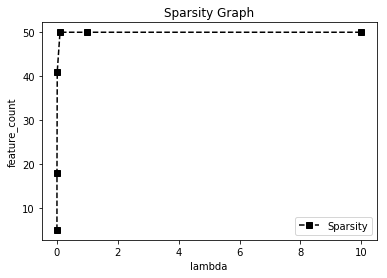

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
[5, 18, 41, 50, 50, 50]


In [118]:
#Graph for feature_count(Sparsity) with increase in lambda value
plt.plot(lambda_list, Sparsity_list, 'ks--',label='Sparsity')
plt.xlabel('lambda')
plt.ylabel('feature_count')
plt.title("Sparsity Graph")
plt.legend()
plt.show()
print(lambda_list)
print(Sparsity_list)

#### Graph  for performance of the model with increase(change) in lambda value 

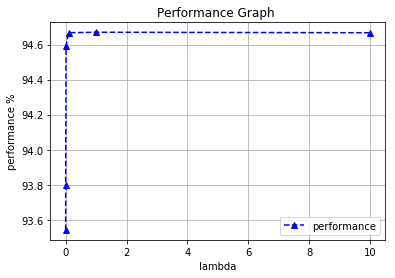

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
[93.54225298547196, 93.79693028228168, 94.59283047440013, 94.66747184078557, 94.66992408122522, 94.66715704303054]


In [120]:
#Graph for performance of the model with increase(change) in lambda value
plt.plot(lambda_list, performance_list, 'b^--' ,label='performance')
plt.xlabel('lambda')
plt.ylabel('performance %')
plt.title("Performance Graph ")
plt.legend()
plt.grid()
plt.show()

print(lambda_list)
print(performance_list)

### RandomizedSearchCV on train data for getting optimal lambda 

In [98]:
#RandomizedSearchCV on train data for getting optimal lambda
from sklearn.model_selection import RandomizedSearchCV
Randomized_parameters = {'C': np.random.uniform(0.0001,10,10000)}

#Using GridSearchCV
model = RandomizedSearchCV(LogisticRegression(), Randomized_parameters, scoring = 'f1_weighted', cv=5)
model.fit(Standardize_X_tr_sent_vectors, y_tr)

print(model.best_estimator_)
print(model.score(Standardize_X_cv_sent_vectors, y_cv))

LogisticRegression(C=5.166978903284563, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8932246320833327


### Performance measure of Test Data on Trained Model with optimal value of lambda

In [99]:
###Performance measure of Test Data on Trained Model with optimal value of lambda
#apply LogisticRegression,l1 reg ,with performace weighted matrix f1_score on Avg_word2vec with optimal value of lambda 
clf = LogisticRegression(C=Avg_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_sent_vectors)

# evaluate weighted f1_score
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (Avg_word2vec_optimal_lambda, sc))


The weighted f1_score of the LogisticRegression with l1 for C = 100.000000  is 88.333678%


In [100]:
#apply LogisticRegression,l1 reg ,with performace matrix f1_score on Avg_word2vec with optimal value of lambda 
clf = LogisticRegression(C=Avg_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_sent_vectors)

# evaluate f1_score
sc = f1_score(y_test, pred) * 100
print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (Avg_word2vec_optimal_lambda, sc))


The f1_score of the LogisticRegression with l1 for C = 100.000000  is 94.433520%


In [101]:
#apply LogisticRegression,l1 reg ,with performace matrix precision on Avg_word2vec with optimal value of lambda 
clf = LogisticRegression(C=Avg_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_sent_vectors)

# evaluate precision_score
sc = precision_score(y_test, pred) * 100
print('\nThe  precision of the LogisticRegression with l1 for C = %f  is %f%%' % (Avg_word2vec_optimal_lambda, sc))


The  precision of the LogisticRegression with l1 for C = 100.000000  is 91.200170%


In [39]:
#apply LogisticRegression,l1 reg ,with performace matrix recall_score on Avg_word2vec with optimal value of lambda 
clf = LogisticRegression(C=Avg_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_sent_vectors, y_tr);
# predict the recall_score
pred = clf.predict(Standardize_X_test_sent_vectors)

# evaluate recall_score
sc = recall_score(y_test, pred) * 100
print('\nThe  recall_score of the LogisticRegression with l1 for C = %f  is %f%%' % (Avg_word2vec_optimal_lambda, sc))


The  recall_score of the LogisticRegression with l1 for C = 100.000000  is 96.869973%

fitting the model with l1 the Sparsity W  is 50



The  confusion_matrix of the LogisticRegression with l1 for C = 100.000000 
[[ 1334  2423]
 [  602 25641]]


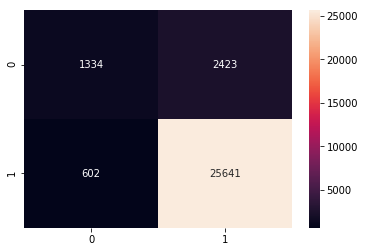

In [29]:
#apply LogisticRegression,l1 reg ,with performace confusion_matrix on Avg_word2vec with optimal value of lambda 
clf = LogisticRegression(C=Avg_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_sent_vectors)

# evaluate confusion_matrix
confusion_matrix_val = confusion_matrix(y_test, pred) 
print('\nThe  confusion_matrix of the LogisticRegression with l1 for C = %f ' % (Avg_word2vec_optimal_lambda))
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [30]:
#apply LogisticRegression,l1 reg ,with performace confusion_matrix on Avg_word2vec with optimal value of lambda 
clf = LogisticRegression(C=Avg_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_sent_vectors)
# evaluate confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix for lambda = %f " %(Avg_word2vec_optimal_lambda))

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for Avg_word2vec *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix for lambda = 100.000000 

******* for Avg_word2vec *********

****TPR is 97%

****FPR is 64%

****FNR is 2%

****TNR is 35%


******* Avg_word2vec Ends ***************


### TF-IDF weighted Word2Vec

In [30]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [31]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_tr_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_tr_list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_tr_tfidf_sent_vectors.append(sent_vec)
    row += 1

print(len(X_tr_tfidf_sent_vectors))
print(len(X_tr_tfidf_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [01:41<00:00, 480.42it/s]


49000
50


In [32]:
#--new way TF-IDF weighted Word2Vec for cv with train data 
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_cv_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_cv_list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_cv_tfidf_sent_vectors.append(sent_vec)
    row += 1

#--------------------------------------------------new way
print(len(X_cv_tfidf_sent_vectors))
print(len(X_cv_tfidf_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [00:48<00:00, 432.97it/s]


21000
50


In [33]:
#--new way TF-IDF weighted Word2Vec for cv with train data 
   # TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test_list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_sent_vectors.append(sent_vec)
    row += 1

#--------------------------------------------------new way
print(len(X_test_tfidf_sent_vectors))
print(len(X_test_tfidf_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:15<00:00, 399.54it/s]


30000
50


### col-std on TF-IDF weighted w2vec

In [34]:
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
# print(scaler.fit(bow_x_tr))
# print(scaler.mean_)
Standardize_X_tr_tfidf_sent_vectors= scaler.fit_transform(X_tr_tfidf_sent_vectors)
# print(Standardize_bow_x_tr)
# print(scaler.mean_)
Standardize_X_cv_tfidf_sent_vectors= scaler.fit_transform(X_cv_tfidf_sent_vectors)
# print(Standardize_bow_x_cv)
# print(scaler.mean_)
Standardize_X_test_tfidf_sent_vectors= scaler.fit_transform(X_test_tfidf_sent_vectors)
# print(Standardize_bow_x_test)
# print(scaler.mean_)


### GridSearchCV on TF-IDF weighted w2vec train data 

In [110]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1_weighted', cv=5)
model.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr)

print(model.best_estimator_)
print(model.score(Standardize_X_cv_tfidf_sent_vectors, y_cv))

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8787264113920238


#### with l1 reg logistic regression apply f1_score as performance matrix on train with cv data

In [35]:
#with l1 reg logistic regression apply f1_score as performance matrix on train with cv data
tfidf_weighted_word2vec_optimal_lambda = 1
clf = LogisticRegression(C=tfidf_weighted_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr);
w = clf.coef_
# predict the response
pred = clf.predict(Standardize_X_cv_tfidf_sent_vectors)

# evaluate f1_score
sc = f1_score(y_cv, pred) * 100
print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_weighted_word2vec_optimal_lambda, sc))
print('\nfitting the model with l1 the Sparsity W  is %d' % (np.count_nonzero(w)))


The f1_score of the LogisticRegression with l1 for C = 1.000000  is 94.349841%

fitting the model with l1 the Sparsity W  is 50


#### with l2 reg logistic regression apply f1_score as performance matrix on train with cv data

In [113]:
#with l2 reg on logistic regression apply f1_score as performance matrix on train with cv data
clf = LogisticRegression(C=tfidf_weighted_word2vec_optimal_lambda, penalty='l2');
clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr);
w = clf.coef_
# print(np.count_nonzero(w))
# predict the response
pred = clf.predict(Standardize_X_cv_tfidf_sent_vectors)

# evaluate f1_score
sc = f1_score(y_cv, pred) * 100
print('\nThe f1_score of the LogisticRegression with l2 for C = %f  is %f%%' % (tfidf_weighted_word2vec_optimal_lambda, sc))


The f1_score of the LogisticRegression with l2 for C = 1.000000  is 94.399958%


### With change in HyperParameter

In [128]:
#Applying L1 reg with change in lambda
i= 0.0001;
Sparsity_list = []
lambda_list = []
performance_list = []
while i< 100:
    clf = LogisticRegression(C=i, penalty='l1');
    clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr);
    w = clf.coef_
    # predict the response
    pred = clf.predict(Standardize_X_cv_tfidf_sent_vectors)

    # evaluate f1_score
    sc = f1_score(y_cv, pred) * 100
#     print("-------------------------------------------------------")
#     print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (i, sc))
#     print('\nfitting the model with l1 the Sparsity W  is %d' % (np.count_nonzero(w)))
    Sparsity_list.append(np.count_nonzero(w))
    lambda_list.append(i)
    performance_list.append(sc)
    i=i*10; 

#### Graph for feature_count(Sparsity) with increase in lambda value

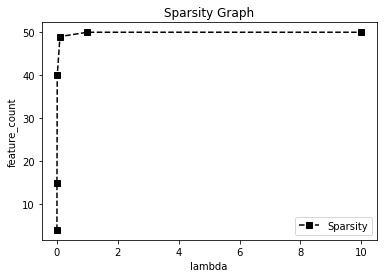

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
[4, 15, 40, 49, 50, 50]


In [129]:
#Graph for feature_count(Sparsity) with increase in lambda value
plt.plot(lambda_list, Sparsity_list, 'ks--',label='Sparsity')
plt.xlabel('lambda')
plt.ylabel('feature_count')
plt.title("Sparsity Graph")
plt.legend()
plt.show()
print(lambda_list)
print(Sparsity_list)

#### Graph for performance of the model with increase(change) in lambda value

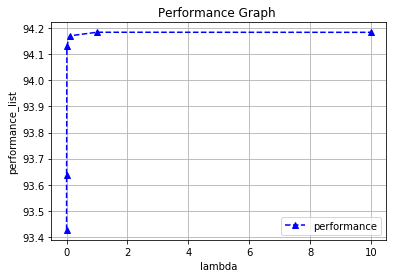

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
[93.42676517632722, 93.63560204107539, 94.13073281771386, 94.1705902244882, 94.18441193314936, 94.18410913256274]


In [130]:
#Graph for performance of the model with increase(change) in lambda value
plt.plot(lambda_list, performance_list, 'b^--' ,label='performance')
plt.xlabel('lambda')
plt.ylabel('performance_list')
plt.title("Performance Graph ")
plt.legend()
plt.grid()
plt.show()
print(lambda_list)
print(performance_list)

### RandomizedSearchCV on train data for getting optimal lambda

In [118]:
#RandomizedSearchCV on train data for getting optimal lambda
from sklearn.model_selection import RandomizedSearchCV
Randomized_parameters = {'C': np.random.uniform(0.0001,10,10000)}

#Using GridSearchCV
model = RandomizedSearchCV(LogisticRegression(), Randomized_parameters, scoring = 'f1_weighted', cv=5)
model.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr)

print(model.best_estimator_)
print(model.score(Standardize_X_cv_tfidf_sent_vectors, y_cv))

LogisticRegression(C=7.956448892311745, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8788397673091582


### Performance measure of Test Data on Trained Model with optimal value of lambda

In [119]:
#apply LogisticRegression,l1 reg ,with performace weighted f1_score on TF-IDF weighted word2vec with optimal value of lambda 
clf = LogisticRegression(C=tfidf_weighted_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_tfidf_sent_vectors)

# evaluate weighted f1_score
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_weighted_word2vec_optimal_lambda, sc))


The weighted f1_score of the LogisticRegression with l1 for C = 1.000000  is 86.887052%


In [120]:
#apply LogisticRegression,l1 reg ,with performace matrix f1_score on TF-IDF weighted word2vec with optimal value of lambda 
clf = LogisticRegression(C=tfidf_weighted_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_tfidf_sent_vectors)

# evaluate f1_score
sc = f1_score(y_test, pred) * 100
print('\nThe f1_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_weighted_word2vec_optimal_lambda, sc))


The f1_score of the LogisticRegression with l1 for C = 1.000000  is 93.988093%


In [42]:
#apply LogisticRegression,l1 reg ,with performace matrix precision_score on TF-IDF weighted word2vec with optimal value of lambda 
clf = LogisticRegression(C=tfidf_weighted_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_tfidf_sent_vectors)

# evaluate precision_score
sc = precision_score(y_test, pred) * 100
print('\nThe precision_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_weighted_word2vec_optimal_lambda, sc))


The precision_score of the LogisticRegression with l1 for C = 100.000000  is 90.151250%


In [121]:
#apply LogisticRegression,l1 reg ,with performace matrix recall_score on TF-IDF weighted word2vec with optimal value of lambda 
clf = LogisticRegression(C=tfidf_weighted_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_tfidf_sent_vectors)

# evaluate recall_score
sc = recall_score(y_test, pred) * 100
print('\nThe recall_score of the LogisticRegression with l1 for C = %f  is %f%%' % (tfidf_weighted_word2vec_optimal_lambda, sc))



The recall_score of the LogisticRegression with l1 for C = 1.000000  is 98.056625%



The  confusion_matrix of the LogisticRegression with l1 for C = 1.000000 
[[ 1007  2750]
 [  493 25750]]


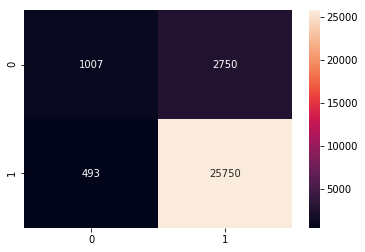

In [38]:
#apply LogisticRegression,l1 reg ,with performace matrix confusion_matrix on TF-IDF weighted word2vec with optimal value of lambda 
clf = LogisticRegression(C=tfidf_weighted_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_tfidf_sent_vectors)

# evaluate confusion_matrix
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe  confusion_matrix of the LogisticRegression with l1 for C = %f ' % (tfidf_weighted_word2vec_optimal_lambda))
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [39]:
#apply LogisticRegression,l1 reg ,with performace confusion_matrix on TF-IDF weighted word2vec with optimal value of lambda 
clf = LogisticRegression(C=tfidf_weighted_word2vec_optimal_lambda, penalty='l1');
clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr);
# predict the response
pred = clf.predict(Standardize_X_test_tfidf_sent_vectors)
# evaluate confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix for lambda = %f " %(tfidf_weighted_word2vec_optimal_lambda))

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for Avg_word2vec *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix for lambda = 1.000000 

******* for Avg_word2vec *********

****TPR is 98%

****FPR is 73%

****FNR is 1%

****TNR is 26%


********* TF-IDF WEIGHTED W2VEC ENDS **********

In [40]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Model" ,"GridsearchCV","RandomSearchCV", "Weighted F1","F1","Recall","precision","TPR","FPR","FNR","TNR"]

x.add_row(["BOW","LG",0.01,0.99,90.45,95.37,98.62,92.3,98,57,1,42])
x.add_row(["TF-IDF","LG",100,7.84,86.64,95.36,98.68,89.97,98,77,1,22])
x.add_row(["AVG W2V","LG",100,0.35,89.21,94.20,96.86,91.68,96,46,3,53])
x.add_row(["TF-IDF W2v","LG",100,8.47,86.47,93,98.11,90.15,98,74,1,25])


print(x)

+------------+-------+--------------+----------------+-------------+-------+--------+-----------+-----+-----+-----+-----+
| Vectorizer | Model | GridsearchCV | RandomSearchCV | Weighted F1 |   F1  | Recall | precision | TPR | FPR | FNR | TNR |
+------------+-------+--------------+----------------+-------------+-------+--------+-----------+-----+-----+-----+-----+
|    BOW     |   LG  |     0.01     |      0.99      |    90.45    | 95.37 | 98.62  |    92.3   |  98 |  57 |  1  |  42 |
|   TF-IDF   |   LG  |     100      |      7.84      |    86.64    | 95.36 | 98.68  |   89.97   |  98 |  77 |  1  |  22 |
|  AVG W2V   |   LG  |     100      |      0.35      |    89.21    |  94.2 | 96.86  |   91.68   |  96 |  46 |  3  |  53 |
| TF-IDF W2v |   LG  |     100      |      8.47      |    86.47    |   93  | 98.11  |   90.15   |  98 |  74 |  1  |  25 |
+------------+-------+--------------+----------------+-------------+-------+--------+-----------+-----+-----+-----+-----+
